In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import math
import numbers
import scipy as sp
import scipy.optimize as op
import pandas as pd
from scipy.interpolate import UnivariateSpline
import os
import sys
from IPython.display import display, Markdown

### Метод Ньютона

Вначале напишем функции для нахождения частных производных, якобиана, а также решения системы уравнений методов Ньютона.

In [2]:
def partial(f, x, var_index, h):
    dim = len(x)
    assert var_index < dim, "Index of variable is greater than dimensity."

    vec_h = np.zeros(dim)
    vec_h[var_index] = h

    return (f(x+vec_h) - f(x-vec_h)) / (2*h)

def getJacobi(f, x, h):
    dim = len(f(x))
    assert dim == len(x), "f and x must be of same size."
    J = np.zeros((dim, dim))

    for i in range(dim):
        for j in range(dim):
            J[i][j] = partial(lambda x: f(x)[i], x, j, h[i])

    return J

def solveSystemNewton(f, x0, n_iter, precision, bl, tr):
    assert precision > 0, "Precision must be positive."
    dim = len(f(x0))
    assert len(x0) == dim and len(bl) == dim and len(tr) == dim, "f, x0, bl and tr must be of same size."
    h = [np.min([np.abs(x0[i] - bl[i]), np.abs(x0[i] - tr[i])]) for i in range(dim)]
    x = x0

    diff = []
    for i in range(n_iter):
        assert np.all(bl < x) and np.all(x < tr), f"Gone out of bounds on iter {i}. Diff: {diff}."
        old_x = x
        x = x - np.matmul(np.linalg.inv(getJacobi(f, x, h)), f(x))
        d = np.abs(x - old_x)
        h = d
        d_norm = np.linalg.norm(d, ord=np.inf)
        diff.append(d_norm)
        if d_norm < precision:
            break

    return x, diff

## Система обыкновенных дифференциальных уравнений

Аристова, Завьялова, Лобанов, VIII.11.5

![title](res/8-11-5.png)

Статья с Википедии о системе Лоренца: https://en.wikipedia.org/wiki/Lorenz_system

А также пример решения в плоскости xOy:

![title](res/lorenz-example.png)

Выпишем систему, а также напишем функцию для отображения решения.

In [3]:
t_begin = 0
t_end = 50

b = 8/3
s = 10
r = 28

y0 = np.array( [1, 1, 1])
def f(t, y_vec):
    assert isinstance( t, numbers.Number), "t must be scalar."
    assert type(y_vec) is np.ndarray, "y_vec must be ndarray."
    assert len(y_vec) == 3, "Invalid number of dimensions."

    x, y, z = y_vec
    result = [
        -s*(x-y),
        -x*z+r*x-y,
        x*y-b*z,
    ]

    return np.array(result)

In [4]:
def drawResult(res_t, res_y):
    x, y, z = res_y.transpose()

    fig, axes = plt.subplots(2, figsize=(10, 10))

    axes[0].scatter(res_t, x, label='x', s=5)
    axes[0].scatter(res_t, y, label='y', s=5)
    axes[0].scatter(res_t, z, label='z', s=5)

    # Draw in xOy plane.
    axes[1].scatter([0], [0], label='center', s=20, color='red')
    axes[1].scatter(x, y, label='trajectory', s=5)

    xlim = axes[1].get_xlim()
    axes[1].set_xlim(xlim[0]*1.2, xlim[1]*1.2)

    axes[1].legend()
    axes[0].legend()

### Явный метод Рунге-Кутты (4 порядка)

Таблица Бутчера взята с этой статьи: https://en.wikipedia.org/w/index.php?title=Runge%E2%80%93Kutta_methods&oldid=1189959645

In [5]:
def classicRK4(t0, y0, h, f, n_iter=None, t_end=None):
    # Sanity checks.
    assert isinstance(t0, numbers.Number), "t0 must be scalar number"
    assert type(y0) is np.ndarray, "y0 must be numpy.ndarray"
    assert isinstance(h, numbers.Number), "h must be scalar number"
    assert type(f(t0, y0)) is np.ndarray, "function value must be numpy.ndarray"
    assert n_iter is None or t_end is None, "specify n_iter or t_end"

    if n_iter is None:
        n_iter = math.ceil((t_end - t_begin) / h)

    # Zero iteration.
    t = t0
    y = y0
    result_t = [t]
    result_y = [y]

    for i in range(n_iter):
        k1 = f(t        , y)
        k2 = f(t + 1/2*h, y + 1/2*k1*h)
        k3 = f(t + 1/2*h, y + 1/2*k2*h)
        k4 = f(t +     h, y +     k3*h)
        y = y + h*(1/6*k1 + 1/3*k2 + 1/3*k3 + 1/6*k4)

        t += h
        result_t.append(t)
        result_y.append(y)

    return np.array(result_t), np.array(result_y)

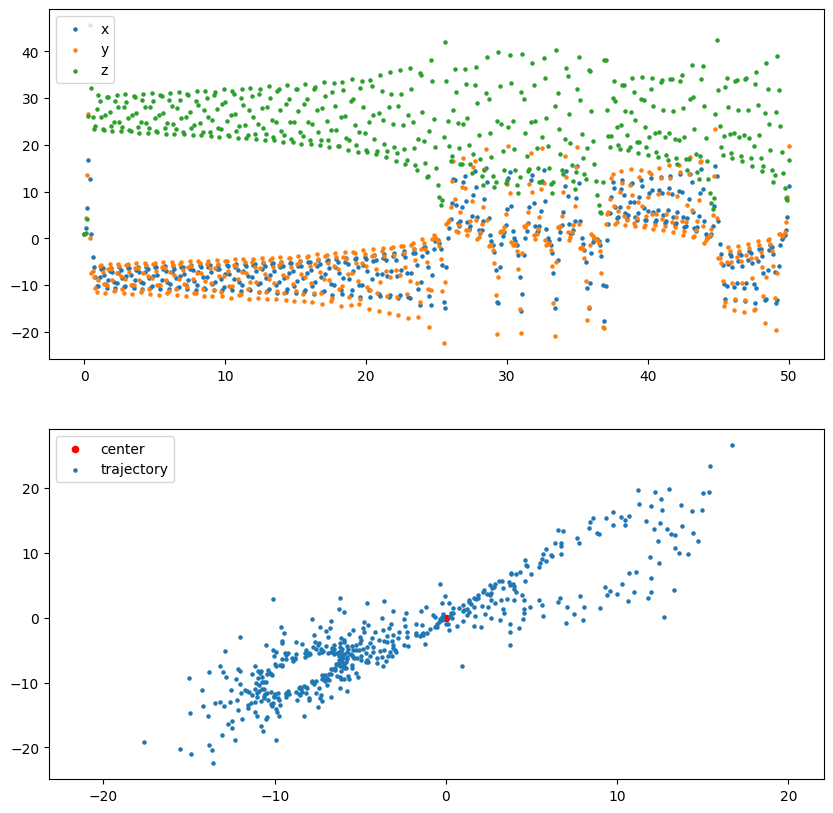

In [6]:
result_t, result_y = classicRK4( t_begin, y0, 0.1, f, t_end=t_end)
drawResult(result_t, result_y)

### Метод Адамса (3 порядка)

In [7]:
def multistepAdams3(t0, y0, h, f, n_iter=None, t_end=None):
    # Sanity checks.
    assert isinstance(t0, numbers.Number), "t0 must be scalar number."
    assert type(y0) is np.ndarray, "y0 must be numpy.ndarray."
    assert isinstance(h, numbers.Number), "h must be scalar number."
    assert type(f(t0, y0)) is np.ndarray, "function value must be numpy.ndarray."
    assert n_iter is None or t_end is None, "specify n_iter or t_end."

    if n_iter is None:
        n_iter = math.ceil((t_end - t_begin) / h)

    # Two iterations have to be precalculated to start.
    # Use Runge-Kutta 4th order method.
    result_t, result_y = classicRK4( t0, y0, h, f, n_iter=2)
    result_t = list(result_t)
    result_y = list(result_y)
    saved_f  = []
    for i in range(3):
        saved_f.append(f(result_t[i], result_y[i]))

    # After two iterations we have 3 points.
    assert len(saved_f) == 3

    t = result_t[2]
    y = result_y[2]
    for i in range(2, n_iter):
        y = y + h*(23/12*saved_f[i] - 16/12*saved_f[i-1] + 5/12*saved_f[i-2])

        t += h
        result_t.append(t)
        result_y.append(y)
        saved_f.append(f(t, y))

    return np.array(result_t), np.array(result_y)

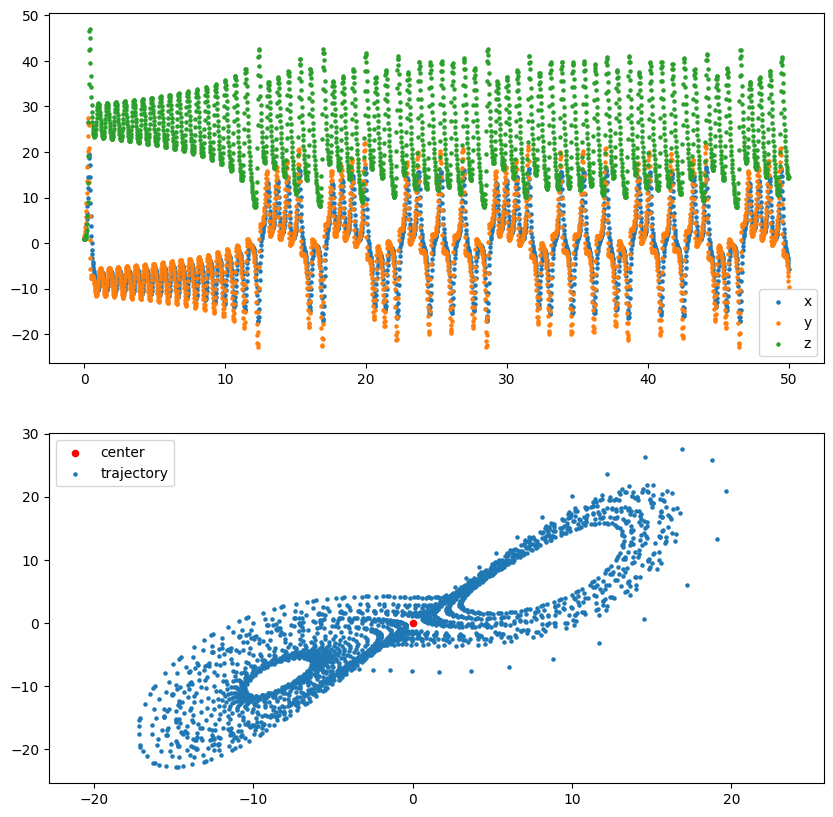

In [8]:
result_t, result_y = multistepAdams3( t_begin, y0, 0.02, f, t_end=t_end)
drawResult(result_t, result_y)

### Метод Формул Дифференцирования Назад (ФДН 3 порядка)

In [9]:
def BDF3(t0, y0, h, f, n_iter=None, t_end=None):
    # Sanity checks.
    assert isinstance(t0, numbers.Number), "t0 must be scalar number"
    assert type(y0) is np.ndarray, "y0 must be numpy.ndarray"
    assert isinstance(h, numbers.Number), "h must be scalar number"
    assert type(f(t0, y0)) is np.ndarray, "function value must be numpy.ndarray"
    assert n_iter is None or t_end is None, "specify n_iter or t_end"

    if n_iter is None:
        n_iter = math.ceil((t_end - t_begin) / h)

    # Two iterations have to be precalculated to start.
    # Use Runge-Kutta 4th order method.
    result_t, result_y = classicRK4( t0, y0, h, f, n_iter=2)

    # Guess deviation on values of initial points.
    deviation = np.max(2*np.add.accumulate(np.abs(result_y))[-1])

    result_t = list(result_t)
    result_y = list(result_y)

    t = result_t[2]
    y = result_y[2]
    for i in range(2, n_iter):
        func = lambda arg: arg - 18/11*result_y[i] + 9/11*result_y[i-1] - 2/11*result_y[i-2] - h*6/11*f(t, arg)
        y, _ = solveSystemNewton(func, y, 10, 1e-4, y-deviation, y+deviation)

        # Check obtained solution.
        y_ref = op.fsolve(func, y)
        assert np.linalg.norm(y_ref - y, ord=np.inf) < 1e-4

        t += h
        result_t.append(t)
        result_y.append(y)

    return np.array(result_t), np.array(result_y)

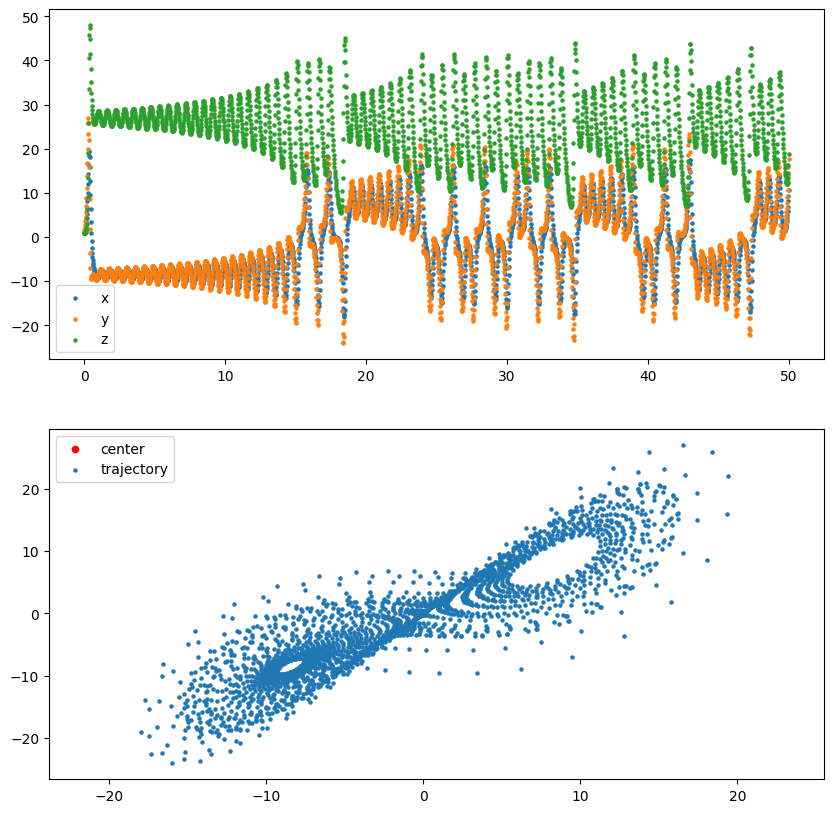

In [10]:
result_t, result_y = BDF3(t_begin, y0, 0.02, f, t_end=t_end)
drawResult(result_t, result_y)

# Системы ОДУ (жесткий вариант)

Аристова, Завьялова, Лобанов, X.9.1

![title](res/10-9-1.png)

Статья на Википедии: https://en.wikipedia.org/wiki/Van_der_Pol_oscillator

Решения в зависимости от параметра `a` (на рисунке обозначен $\mu$):

![title](res/vanderpol-example.png)\

Выпишем систему и функцию для отображения системы:

In [24]:
a = 10

t_begin = 0
t_end = 20

y0 = np.array([2, 0])
def f(t, y):
    assert isinstance( t, numbers.Number), "t must be scalar"
    assert type(y) is np.ndarray, "y must be ndarray"
    assert len(y) == 2, "invalid number of dimensions"

    y1_0, y2_0 = y0
    y1, y2 = y
    result = [
        y2,
        a*y2*(1-y1*y1)-y1,
    ]

    return np.array(result)

In [25]:
def drawResult(res_t, res_y):
    fig, axes = plt.subplots(2, figsize=(10, 10))
    y1, y2 = res_y.transpose()
    axes[0].plot(res_t, y1, label='y1')
    axes[0].plot(res_t, y2, label='y2')

    axes[1].plot(y1, y2, label='y1 y2')

    axes[0].legend()
    axes[1].legend()

### Метод Формулы Дифференцирования назад для жесткой задачи

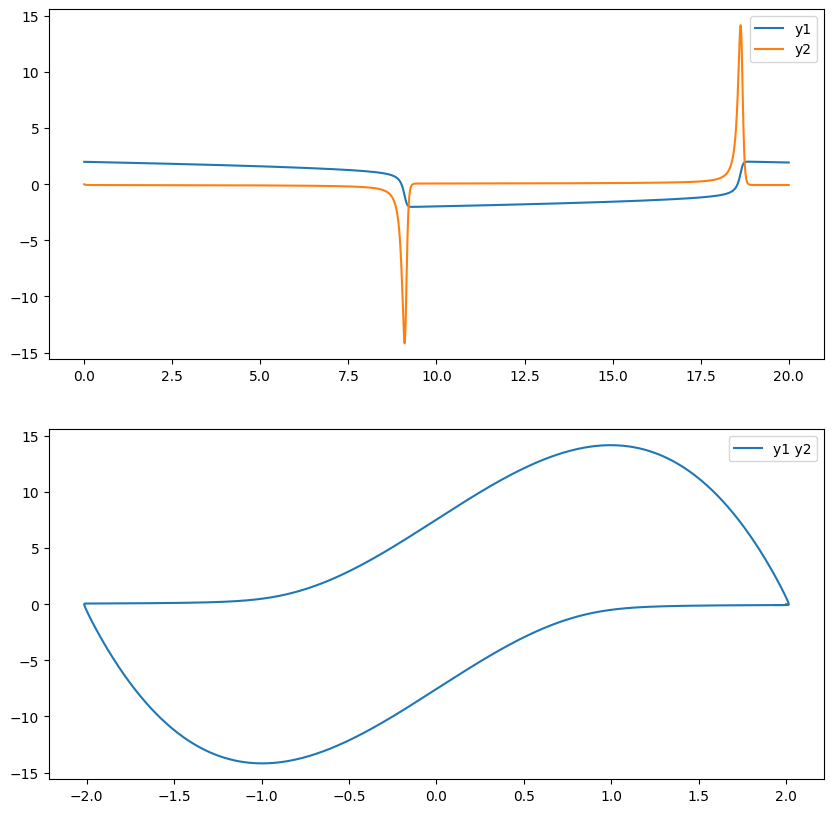

In [26]:
result_t, result_y = BDF3( t_begin, y0, 0.001, f, t_end=t_end)
drawResult(result_t, result_y)

### Неявный метод Рунге-Кутты (3 порядок)

In [27]:
def implicitRK3(t0, y0, h, f, n_iter=None, t_end=None):
    # Sanity checks.
    assert isinstance(t0, numbers.Number), "t0 must be scalar number"
    assert type(y0) is np.ndarray, "y0 must be numpy.ndarray"
    assert isinstance(h, numbers.Number), "h must be scalar number"
    assert type(f(t0, y0)) is np.ndarray, "function value must be numpy.ndarray"
    assert n_iter is None or t_end is None, "specify n_iter or t_end"

    if n_iter is None:
        n_iter = math.ceil((t_end - t_begin) / h)

    # Zero iteration.
    t = t0
    y = y0
    result_t = [t]
    result_y = [y]

    for i in range(n_iter):
        k1 = op.fsolve(lambda arg: arg - f(t + 1/3*h, y + h*(1/3*arg)),          y)
        k2 = op.fsolve(lambda arg: arg - f(t +     h, y + h*(1/3*k1 + 2/3*arg)), y)
        k3 = op.fsolve(lambda arg: arg - f(t +     h, y + h*(arg)),              y)
        y = y + h*(3/4*k1 + 3/4*k2 - 1/2*k3)

        t += h
        result_t.append(t)
        result_y.append(y)

    return np.array(result_t), np.array(result_y)

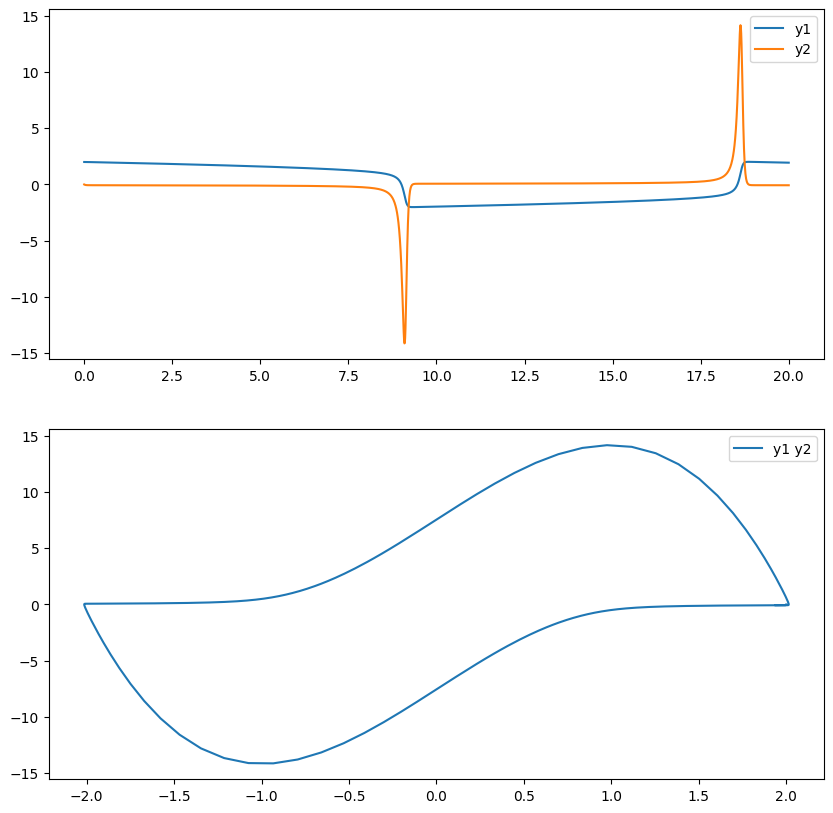

In [28]:
result_t, result_y = implicitRK3(t_begin, y0, 0.001, f, t_end=t_end)
drawResult(result_t, result_y)

### Метод Розенброка

In [29]:
def CROS(t0, y0, h, f, n_iter=None, t_end=None):
    # Sanity checks.
    assert isinstance(t0, numbers.Number), "t0 must be scalar number."
    assert type(y0) is np.ndarray, "y0 must be numpy.ndarray."
    assert isinstance(h, numbers.Number), "h must be scalar number."
    assert type(f(t0, y0)) is np.ndarray, "function value must be numpy.ndarray."
    assert n_iter is None or t_end is None, "specify n_iter or t_end."

    if n_iter is None:
        n_iter = math.ceil((t_end - t_begin) / h)

    # Zero iteration.
    t = t0
    y = y0
    result_t = [t]
    result_y = [y]

    for i in range(n_iter):
        # Get df/du Jacobian.
        J = getJacobi(lambda arg: f(t, arg), y, np.full_like(y0, 1))

        # Aw = b
        b = f(t + h/2, y)
        A = (np.eye(len(y0)) - (1+1j)/2*h*J)
        w = np.linalg.solve(A, b)
        y = y + h*np.real(w)

        t += h
        result_t.append(t)
        result_y.append(y)

    return np.array(result_t), np.array(result_y)

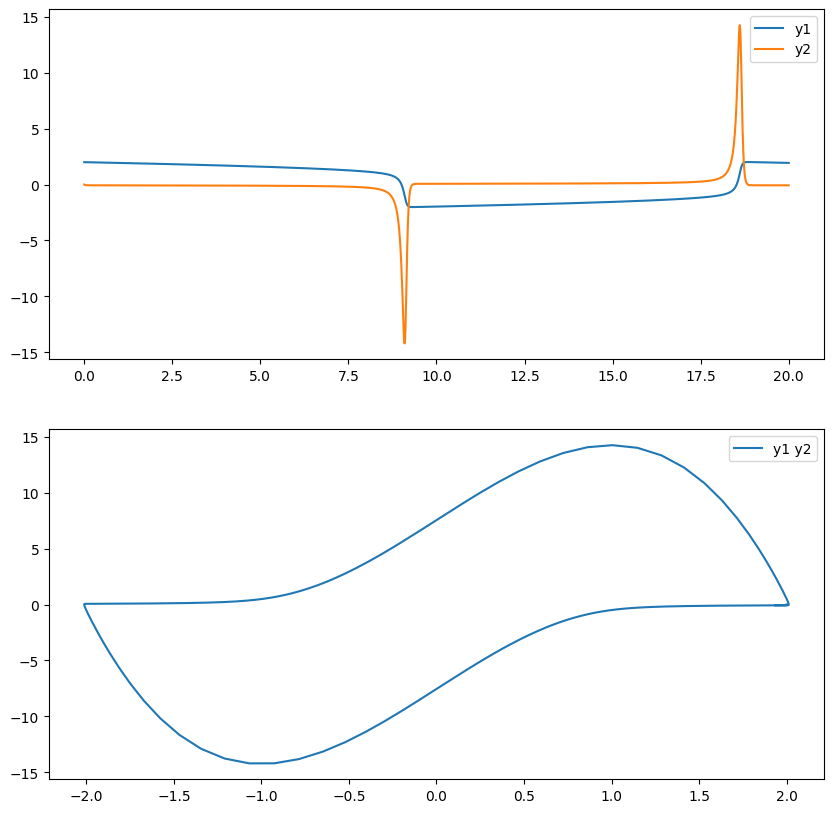

In [30]:
result_t, result_y = CROS(t_begin, y0, 0.001, f, t_end=t_end)
drawResult(result_t, result_y)

### Метод ФДН в представлении Нордсика (3 порядок)

In [31]:
def nordsikBDF3(t0, y0, h, f, n_iter=None, t_end=None):
    # Sanity checks.
    assert isinstance(t0, numbers.Number), "t0 must be scalar number."
    assert type(y0) is np.ndarray, "y0 must be numpy.ndarray."
    assert isinstance(h, numbers.Number), "h must be scalar number."
    assert type(f(t0, y0)) is np.ndarray, "function value must be numpy.ndarray."
    assert n_iter is None or t_end is None, "specify n_iter or t_end."

    if n_iter is None:
        n_iter = math.ceil((t_end - t_begin) / h)

    # Zero iteration.
    t = t0
    y = y0
    result_t = [t0]
    result_y = [y0]

    dim = 4
    P = sp.linalg.pascal(dim, kind='upper')
    l = np.array([6/11, 1, 6/11, 1/11])
    e1 = np.zeros(dim)
    e1[1] = 1
    z = np.zeros((dim, len(y0)))
    z[0] = y0

    for i in range(n_iter):
        # Case dim = 4, len(y) = 2:
        #
        # zz = PPPP zz + l (h*ff - eeee PPPP zz)
        # zz = PPPP zz   l (            PPPP zz)
        # zz = PPPP zz   l (            PPPP zz)
        # zz = PPPP zz   l (            PPPP zz)
        z = np.matmul(P, z) + np.outer(l, (h*f(t, y) - np.dot(e1, np.matmul(P, z))))

        y = z[0]
        t += h
        result_t.append(t)
        result_y.append(y)

    return np.array(result_t), np.array(result_y)

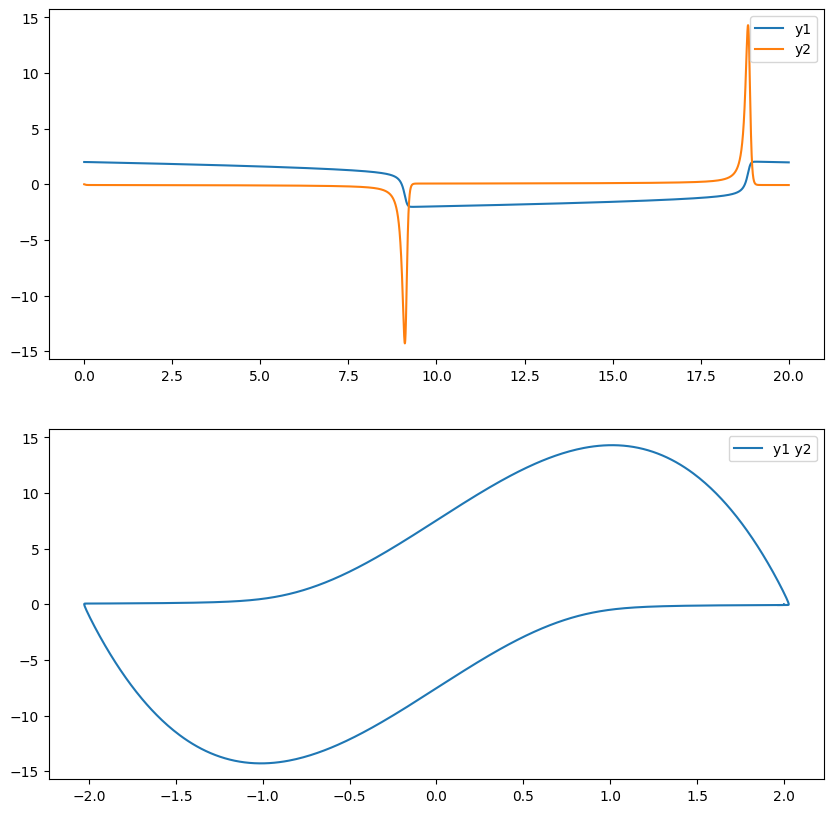

In [32]:
result_t, result_y = nordsikBDF3(t_begin, y0, 0.001, f, t_end=t_end)
drawResult(result_t, result_y)

# Метод прогонки

Аристова, Завьялова, Лобанов, XI.9.5

![title](res/11-9-5.png)
![title](res/11-9-5(2).png)

In [20]:
h = 0.005
p = lambda x: 0
q = lambda x: -(10 + np.sin(2*np.pi*x))
f = lambda x: np.cos(2*np.pi*x)

In [21]:
def periodicTridiagonal(pk, qk, fk, h):
    N = len(fk)

    a = 1 - 1/2 * pk * h
    b = 2 - qk * h**2
    c = 1 + 1/2 * pk * h
    phi = fk * h**2

    alpha = np.ndarray(N)
    beta = np.ndarray(N)
    gamma = np.ndarray(N)

    alpha[1] = c[0]/b[0]
    beta[1] = -phi[0]/b[0]
    gamma[1] = a[0]/b[0]

    for k in range(1, N-1):
        alpha[k+1] = c[k]/(b[k] - alpha[k]*a[k])
        beta[k+1] = (a[k]*beta[k] - phi[k]) / (b[k] - alpha[k]/a[k])
        gamma[k+1] = a[k]*gamma[k] / (b[k] - alpha[k]*a[k])

    mu = np.ndarray(N)
    nu = np.ndarray(N)

    mu[N-1] = -c[N-1] / (a[N-1]*(alpha[N-1] + gamma[N-1]) - b[N-1])
    nu[N-1] = (phi[N-1] - a[N-1]*beta[N-1]) / (a[N-1]*(alpha[N-1] + gamma[N-1]) - b[N-1])

    for n in reversed(range(1, N)):
        mu[n-1] = alpha[n]*mu[n] + gamma[n]*mu[N-1]
        nu[n-1] = beta[n] + alpha[n]*nu[n] + gamma[n]*nu[N-1]

    y = np.ndarray(N)

    y[0] = nu[0] / (1 - mu[0])
    y[N-1] = mu[N-1]*y[0] + nu[N-1]

    for n in reversed(range(1, N)):
        y[n-1] = alpha[n]*y[n] + beta[n] + gamma[n]*y[N-1]

    return y

def solvePeriodic(p, q, f, h):
    T = 1.0
    N = int(T/h + 1)
    xk = np.array(np.linspace(0, 1, N))
    assert (xk[1] - xk[0]) <= h

    pk = np.array([p(x) for x in xk])
    qk = np.array([q(x) for x in xk])
    fk = np.array([f(x) for x in xk])

    yk = periodicTridiagonal(pk, qk, fk, h)

    return xk, yk

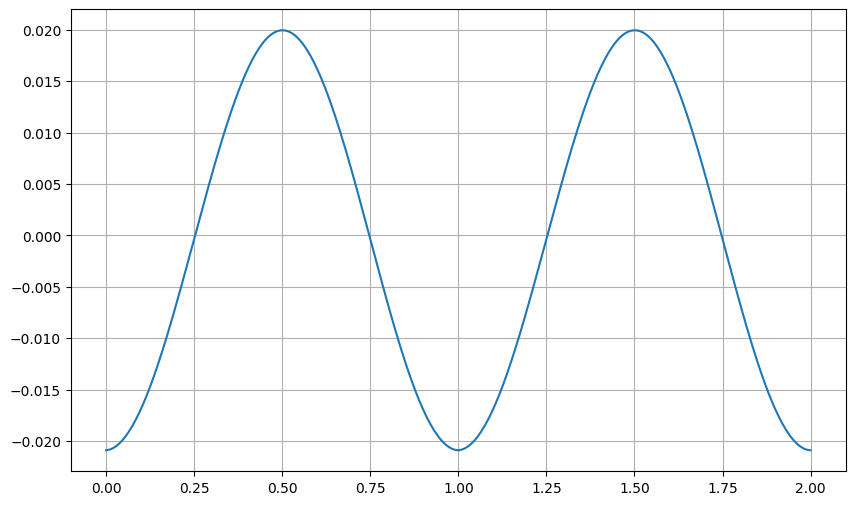

In [22]:
x, y = solvePeriodic(p, q, f, 0.005)

# Check that function is periodical.
n_periods = 2
y = np.tile(y, n_periods)
x = np.concatenate([x + i for i in range(0, n_periods)])

plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.grid()